# Prepare simulation data

In [4]:
import os
import glob
import pickle

import collections

import numpy as np
import pyccl as ccl

from baryon_painter.utils.datasets import BAHAMASDataset

pi = np.pi

### Calculate comoving sizes of SLICS lightcone mass sheets

In [5]:
n_grid_BAHAMAS = 2048
L_BAHAMAS = 400

pixel_size_phys_BAHAMAS = L_BAHAMAS/n_grid_BAHAMAS

SLICS_filenames = glob.glob("../data/training_data/SLICS/delta/*delta.dat_bicubic_LOS299")

z_SLICS = [float(z[:z.find("delta")]) for z in [os.path.split(f)[1] for f in SLICS_filenames]]
z_SLICS = np.array(sorted(z_SLICS))

n_grid_SLICS = 7745
theta_SLICS = 10/180*pi

pixel_size_ang_SLICS = theta_SLICS/n_grid_SLICS


Omega_m = 0.2905
Omega_b = 0.0473
Omega_L = 0.7095
h = 0.6898
sigma_8 = 0.826
n_s = 0.969
cosmo = ccl.Cosmology(Omega_c=(1-Omega_L-Omega_b), Omega_b=Omega_b, Omega_k=0,
                      h=h, sigma8=sigma_8, n_s=n_s)

d_A_SLICS = ccl.comoving_angular_distance(cosmo, 1/(1+z_SLICS))*h # units of Mpc/h

pixel_size_phys_SLICS = pixel_size_ang_SLICS*d_A_SLICS

beam_Planck = 10/60/180*pi

print(f"pixel size BAHAMAS (Mpc / h): {pixel_size_phys_BAHAMAS:.2f}")
print()
print("z        pixel size SLICS (Mpc / h)    scaled n_pixel     Beam size Planck (Mpc / h)")
for z, d_A, p in zip(z_SLICS, d_A_SLICS, pixel_size_phys_SLICS):
    s = pixel_size_phys_BAHAMAS/p
    print(f"{z:.3f}              {p:.4f}                {n_grid_SLICS/s:6.1f}             {d_A*beam_Planck:6.2f}")

pixel size BAHAMAS (Mpc / h): 0.20

z        pixel size SLICS (Mpc / h)    scaled n_pixel     Beam size Planck (Mpc / h)
0.042              0.0028                 111.5               0.36
0.130              0.0085                 338.1               1.10
0.221              0.0142                 562.4               1.83
0.317              0.0199                 787.7               2.56
0.418              0.0255                1012.2               3.29
0.525              0.0312                1236.4               4.02
0.640              0.0369                1462.2               4.76
0.764              0.0426                1689.2               5.50
0.897              0.0483                1915.0               6.23
1.041              0.0540                2140.5               6.97
1.199              0.0597                2367.6               7.71
1.372              0.0654                2594.4               8.45
1.562              0.0711                2820.5               9.18
1.772   

The physical size of the Planck beam (assuming 10 arcmin, which is overestimating it) at the lowest redshift slice (z = 0.042) is larger than the BAHAMAS pixel size (assuming 1024 grids). We should therefore move to 2048 grids for BAHAMAS.

In [6]:
d_A_SLICS*10/180*pi

array([ 21.77289306,  66.04365283, 109.84830539, 153.84825741,
       197.697986  , 241.48144097, 285.5942848 , 329.93113006,
       374.02564268, 418.07151683, 462.41309736, 506.7112455 ,
       550.87041767, 594.9417124 , 639.21982146, 683.2874715 ,
       727.47174576, 771.44956095])

# BAHAMAS sheet combination strategy

The SLICS mass sheets are 252.5 Mpc $h^{-1}$ deep, which is $\approx 5\times 50$ Mpc h$^{-1}$. To retain as much line-of-sight correlation as possible while ensuring sufficent number of training samples, we split the boxes into $3\times 50$ Mpc h$^{-1}$ and $2\times 50$ Mpc h$^{-1}$ slices that can be combined arbitrarily to give $5\times 50$ Mpc h$^{-1}$ slices.

We split 
- six projections into two 150 Mpc h$^{-1}$ slices and one 100 Mpc h$^{-1}$ slice, 
- two projections into one 150 Mpc h$^{-1}$ slices and two 100 Mpc h$^{-1}$ slice, 
- one projecction into four 100 Mpc h$^{-1}$ slices,

for a total of 14 of both 150 Mpc h$^{-1}$ and 100 Mpc h$^{-1}$ slices. These slices are split into $4\times 4=16$ slices, such that the total number of combinations that can be made is $(14\cdot 16)^2=50176$, which should be sufficient for our purposes.

The last volume is used for testing and validation. It is split into
- two projections into two 150 Mpc h$^{-1}$ slices and one 100 Mpc h$^{-1}$ slice, 
- one projections into one 150 Mpc h$^{-1}$ slices and two 100 Mpc h$^{-1}$ slice, 

for five 150 Mpc h$^{-1}$ and four 100 Mpc h$^{-1}$ slices, which can be combined into $(5\cdot 16)(4\cdot 16)=5120$ 250 Mpc h$^{-1}$ equivalent slices.

We're using `numpy.save` instead of `numpy.savez` because the latter is very slow at access time (something about lazy loading of the file).

In [283]:
stack_slices = {  # 3 x (2 x 150Mpc/h + 1 x 100 Mpc/h)
                  "v1" : {"x" : (slice(0, 3), slice(3,6), slice(6,8)),
                          "y" : (slice(0, 3), slice(3,6), slice(6,8)),
                          "z" : (slice(0, 3), slice(3,6), slice(6,8))},
                  # 3 x (2 x 150Mpc/h + 1 x 100 Mpc/h)
                  "v2" : {"x" : (slice(0, 3), slice(3,6), slice(6,8)),
                          "y" : (slice(0, 3), slice(3,6), slice(6,8)),
                          "z" : (slice(0, 3), slice(3,6), slice(6,8))},
                  # 2 x (1 x 150Mpc/h + 2 x 100 Mpc/h) + 1 x (4 x 100 Mpc/h)
                  "v3" : {"x" : (slice(0, 3), slice(3,5), slice(5,7)),
                          "y" : (slice(0, 3), slice(3,5), slice(5,7)),
                          "z" : (slice(0, 2), slice(2,4), slice(4,6), slice(6,8))},
                  # Test & validation volume: 2 x (2 x 150Mpc/h + 1 x 100 Mpc/h) + 1 x (1 x 150Mpc/h + 2 x 100 Mpc/h) 
                  "v4" : {"x" : (slice(0, 3), slice(3,6), slice(6,8)),
                          "y" : (slice(0, 3), slice(3,6), slice(6,8)),
                          "z" : (slice(0, 3), slice(3,5), slice(5,7)),},
                }

test_volumes = ["v4"]

z2snap = {0.0 : 32,
          0.5 : 28,
          1.0 : 26,
          2.0 : 22,}


n_sheet = 8 # Sheets in cube
n_stack = 14
n_grid = 2048

slices_100Mpc = []
slices_150Mpc = []

test_slices_100Mpc = []
test_slices_150Mpc = []


filename_template = "../data/training_data/BAHAMAS/M2048S8/AGN_TUNED_nu0_{volume}_L400N1024_WMAP9_snap{snap}_{field}_sheets"

out_path = "../data/training_data/BAHAMAS/stacks_uncompressed/"
out_filename_template = "{field}_z{z:.1f}_train"
test_out_filename_template = "{field}_z{z:.1f}_test"

info_dicts = []
info_test_dicts = []

for field in ["dm", "gas", "pressure", "stars"]:
    print(f"Processing {field}.")
    for redshift in [0.0, 0.5, 1.0, 2.0]:
        print(f" -> Processing z = {redshift:.1f}")
        slices_100Mpc = []
        slices_150Mpc = []
        test_slices_100Mpc = []
        test_slices_150Mpc = []

        for v in ["v1", "v2", "v3", "v4"]:
            print(f"     -> Processing {v}")
            
            filename = filename_template.format(volume=v, field=field, snap=z2snap[redshift])
            print(f"Reading {filename}.")
            data = np.fromfile(filename, dtype=np.float32)
            data = data.reshape(3, n_sheet, n_grid, n_grid, order="F")
            
            for i, projection in enumerate(["x", "y", "z"]):
                for s in stack_slices[v][projection]:
                    stack = data[i][s]
                    if v in test_volumes:
                        if stack.shape[0] == 3:
                            test_slices_150Mpc.append(stack.sum(axis=0))
                        elif stack.shape[0] == 2:
                            test_slices_100Mpc.append(stack.sum(axis=0))
                        else:
                            raise RuntimeError(f"Illegal stack size {stack.shape[0]}")
                    else:
                        if stack.shape[0] == 3:
                            slices_150Mpc.append(stack.sum(axis=0))
                        elif stack.shape[0] == 2:
                            slices_100Mpc.append(stack.sum(axis=0))
                        else:
                            raise RuntimeError(f"Illegal stack size {stack.shape[0]}")
                        
        slices_100Mpc = np.array(slices_100Mpc)
        slices_150Mpc = np.array(slices_150Mpc)
        
        mean_100 = slices_100Mpc.mean()
        var_100 = slices_100Mpc.var(ddof=1)
        mean_150 = slices_150Mpc.mean()
        var_150 = slices_150Mpc.var(ddof=1)
        
        test_slices_100Mpc = np.array(test_slices_100Mpc)
        test_slices_150Mpc = np.array(test_slices_150Mpc)
        
        test_mean_100 = test_slices_100Mpc.mean()
        test_var_100 = test_slices_100Mpc.var(ddof=1)
        test_mean_150 = test_slices_150Mpc.mean()
        test_var_150 = test_slices_150Mpc.var(ddof=1)
        
        out_filename = out_filename_template.format(field=field, z=redshift)
        print(f"Writing to {out_filename}")
        np.save(os.path.join(out_path, out_filename+"_100"), slices_100Mpc)
        np.save(os.path.join(out_path, out_filename+"_150"), slices_150Mpc)
        
        info = {"field"    : field,
                "z"        : redshift,
                "n_grid"   : n_grid,
                "n_sheet"  : n_sheet,
                "n_stack"  : n_stack,
                "mean_100" : mean_100,
                "mean_150" : mean_150,
                "var_100"  : var_100,
                "var_150"  : var_150,
                "file_100" : out_filename+"_100.npy",
                "file_150" : out_filename+"_150.npy"}
        info_dicts.append(info)
        
        test_out_filename = test_out_filename_template.format(field=field, z=redshift)
        print(f"Writing to {test_out_filename}")
        np.save(os.path.join(out_path, test_out_filename+"_100"), test_slices_100Mpc)
        np.save(os.path.join(out_path, test_out_filename+"_150"), test_slices_150Mpc)
        
        info_test = {"field"    : field,
                     "z"        : redshift,
                     "n_grid"   : n_grid,
                     "n_sheet"  : n_sheet,
                     "n_stack"  : n_stack,
                     "mean_100" : test_mean_100,
                     "mean_150" : test_mean_150,
                     "var_100"  : test_var_100,
                     "var_150"  : test_var_150,
                     "file_100" : test_out_filename+"_100.npy",
                     "file_150" : test_out_filename+"_150.npy"}
        info_test_dicts.append(info_test)

with open(os.path.join(out_path, "train_files_info.pickle"), "wb") as f:        
    pickle.dump(info_dicts, f)
with open(os.path.join(out_path, "test_files_info.pickle"), "wb") as f:        
    pickle.dump(info_test_dicts, f)
  
    
    

Processing dm.
 -> Processing z = 0.0
     -> Processing v1
Reading ../data/training_data/BAHAMAS/M2048S8/AGN_TUNED_nu0_v1_L400N1024_WMAP9_snap32_dm_sheets.
     -> Processing v2
Reading ../data/training_data/BAHAMAS/M2048S8/AGN_TUNED_nu0_v2_L400N1024_WMAP9_snap32_dm_sheets.
     -> Processing v3
Reading ../data/training_data/BAHAMAS/M2048S8/AGN_TUNED_nu0_v3_L400N1024_WMAP9_snap32_dm_sheets.
     -> Processing v4
Reading ../data/training_data/BAHAMAS/M2048S8/AGN_TUNED_nu0_v4_L400N1024_WMAP9_snap32_dm_sheets.
Writing to dm_z0.0_train
Writing to dm_z0.0_test
 -> Processing z = 0.5
     -> Processing v1
Reading ../data/training_data/BAHAMAS/M2048S8/AGN_TUNED_nu0_v1_L400N1024_WMAP9_snap28_dm_sheets.
     -> Processing v2
Reading ../data/training_data/BAHAMAS/M2048S8/AGN_TUNED_nu0_v2_L400N1024_WMAP9_snap28_dm_sheets.
     -> Processing v3
Reading ../data/training_data/BAHAMAS/M2048S8/AGN_TUNED_nu0_v3_L400N1024_WMAP9_snap28_dm_sheets.
     -> Processing v4
Reading ../data/training_data/BAHAM

     -> Processing v3
Reading ../data/training_data/BAHAMAS/M2048S8/AGN_TUNED_nu0_v3_L400N1024_WMAP9_snap26_stars_sheets.
     -> Processing v4
Reading ../data/training_data/BAHAMAS/M2048S8/AGN_TUNED_nu0_v4_L400N1024_WMAP9_snap26_stars_sheets.
Writing to stars_z1.0_train
Writing to stars_z1.0_test
 -> Processing z = 2.0
     -> Processing v1
Reading ../data/training_data/BAHAMAS/M2048S8/AGN_TUNED_nu0_v1_L400N1024_WMAP9_snap22_stars_sheets.
     -> Processing v2
Reading ../data/training_data/BAHAMAS/M2048S8/AGN_TUNED_nu0_v2_L400N1024_WMAP9_snap22_stars_sheets.
     -> Processing v3
Reading ../data/training_data/BAHAMAS/M2048S8/AGN_TUNED_nu0_v3_L400N1024_WMAP9_snap22_stars_sheets.
     -> Processing v4
Reading ../data/training_data/BAHAMAS/M2048S8/AGN_TUNED_nu0_v4_L400N1024_WMAP9_snap22_stars_sheets.
Writing to stars_z2.0_train
Writing to stars_z2.0_test


## Dataset and dataloader

In [7]:
with open("../data/training_data/BAHAMAS/stacks_uncompressed/train_files_info.pickle", "rb") as f:
    training_files_info = pickle.load(f)

def transform_to_delta(x, field, z, **kwargs):
    return x/kwargs["mean"]-1

def inv_transform_to_delta(x, field, z, **kwargs):
    return (x+1)*kwargs["mean"]


dataset = BAHAMASDataset(training_files_info, root_path="../data/training_data/BAHAMAS/stacks_uncompressed/",
                         transform=transform_to_delta,
                         inverse_transform=inv_transform_to_delta)

# %timeit dataset.get_stack("dm", 0.0, 36342)
# s, transforms = dataset.get_stack("dm", 0.0, 124)
s, inv_transforms = dataset[124]

len(s)

4

# Check histograms between SLICS and BAHAMAS

## Check lightcone generation

z: redshift of middle of comoving distance of half box (starting at 0)


In [29]:
import matplotlib.pyplot as plt

from cosmotools.plotting import subplot_colorbar

In [378]:
def select_cutout(d, shift, size, subtract_mean=False):
    if subtract_mean:
        d_mean = d.astype(np.float64).mean()
    else:
        d_mean = 0
        
    x1 = shift[0]
    y1 = shift[1]
    
    x2 = shift[0] + size
    y2 = shift[1] + size
    
    if x2 < d.shape[0] and y2 < d.shape[1]:
        return d[x1:x2,y1:y2] - d_mean
    elif x2 < d.shape[0] and y2 >= d.shape[1]:
        return np.concatenate((d[x1:x2,y1:], d[x1:x2,:y2-d.shape[1]]), axis=1) - d_mean
    elif x2 >= d.shape[0] and y2 < d.shape[1]:
        return np.concatenate((d[x1:,y1:y2], d[:x2-d.shape[0],y1:y2]), axis=0) - d_mean

shifts = np.loadtxt("../data/training_data/SLICS/random_shift_LOS1097")[::-1]

projection = lambda idx: ["xy", "xz", "yz"][idx%3]
z_idx = 0

pixel_shifts = (shifts[z_idx]*12288).astype(int)
pixel_size = int(d_A_SLICS[z_idx]*10/180*pi/505*12288)

plane = select_cutout(np.fromfile(f"../data/training_data/SLICS/massplanes/{z_SLICS[z_idx]:.3f}proj_half_finer_{projection(z_idx)}.dat_LOS1097", dtype=np.float32)[1:].reshape(4096*3, -1).T,
                      pixel_shifts, pixel_size, subtract_mean=True)

plane *= 64
plane -= plane.min()
plane = plane/plane.mean() - 1

delta = np.fromfile(f"../data/training_data/SLICS/delta/{z_SLICS[z_idx]:.3f}delta.dat_bicubic_LOS1097", dtype=np.float32).reshape(7745, -1).T
delta *= 64
delta -= delta.min()
delta = delta[::7, ::7]

delta = delta/delta.mean() - 1

/Users/yooken/Codes/miniconda/envs/python3_stack/lib/python3.6/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log


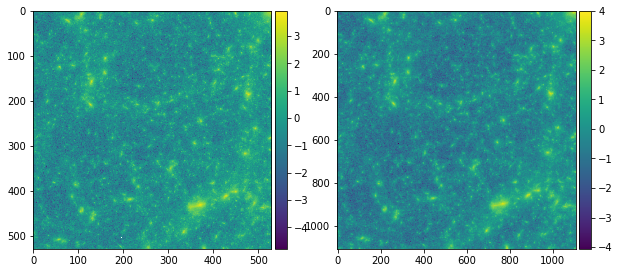

In [379]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# fig.subplots_adjust(wspace=0)

im = ax[0].imshow(np.log(plane+1))
# im = ax[0].imshow(plane[:11,:11])

subplot_colorbar(im, ax[0])
im = ax[1].imshow(np.log(delta+1))
# im = ax[1].imshow(delta[:7745//53,:7745//53])

subplot_colorbar(im, ax[1])


In [251]:
plane.shape

(529, 529)

In [312]:
dm_fraction = cosmo.params.parameters.Omega_c/cosmo.params.parameters.Omega_m

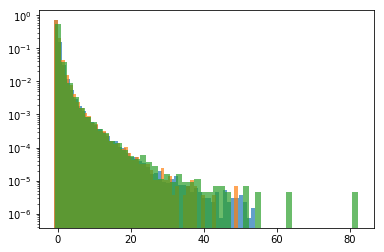

In [386]:
# _ = plt.hist(delta.flatten()/1536*dm_fraction, bins=50, alpha=0.7, density=True)
# _ = plt.hist(plane.flatten()/1536*dm_fraction, bins=50, alpha=0.7, density=True)
# _ = plt.hist(s[0].flatten()/250, bins=50, alpha=0.7, density=True)

_ = plt.hist(delta.flatten(), bins=50, alpha=0.7, density=True)
_ = plt.hist(plane.flatten(), bins=50, alpha=0.7, density=True)
_ = plt.hist(s[0].flatten(), bins=50, alpha=0.7, density=True)

plt.yscale("log")

In [192]:
print(delta.min(), delta.max(), delta.mean())
print(plane.min(), plane.max(), plane.mean())

-0.98273265 53.88665 -1.0001118e-07
-0.9854776 48.603485 1.832095e-08


In [46]:
shifts[0]*12288
(shifts[0]+21.77/505)*12288

array([  705.18787266, 12757.37073121])

In [49]:
pixel_size

529